# there is the SHAPE dataset of 50 sequences, under 4 conditions... 

we want to see of our accessibility is good

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

backend module://ipykernel.pylab.backend_inline version unknown


# Load data

In [2]:
import simushape as ss 
from scipy.stats import spearmanr as spear
import pandas
import numpy as np

def run_access(data, keys):
    shaker_shape = ss.crosspredict(data,keys)
    seqs = [data[k][1] for k in keys] 
    acc_shaker = [rnaplfold(seq, rea) for seq,rea in zip(seqs,shaker_shape)]
    acc_nothing = [rnaplfold(seq) for seq in seqs]
    acc_real  = [rnaplfold(data[k][1],data[k][0]) for k in keys]
    corr = lambda other: [spear(accr, acco)[0] for accr,acco in zip(acc_real, other)]
    corr_shaker = corr(acc_shaker)
    corr_default = corr(acc_nothing)
    
    index= ['shaker', 'default']
    data = [corr_shaker,corr_default]
    map(lambda x:x.append(np.mean(x)),data)
    print pandas.DataFrame(data, columns=keys+['mean'], index=index).T
    

In [3]:
import rna_tools.rna_io as rio
import pandas

# TODO: add 4th there is no 4th 

types = ["cellfree",
"incell",
"kasugamycin"]


def getdata(typ):
    return rio.get_all_data("../data/weeks194_orig/%s.react" % typ,"../data/weeks194_orig/%s.dbn" % typ)  # {key: rea, seq, stru}

data = [getdata(t) for t in types] # 2 has bad results :)

# select 10 smallest
l = [ (len(v[1]),k) for k,v in data[0].items()]
l.sort()
keys=[ e[1] for e in l[:10]]
print (keys)
shape = [ss.crosspredict_nfold(dat,keys) for dat in data]


blobs = [ pandas.DataFrame([a,b,c], index=types) for a,b,c in zip(*shape)  ]



['ncRNA_ssrS_107', '_157', 'ncRNA_gcvB_105', 'cspE_28', 'lpp_61', 'rpsU_113', 'ytfK_189', 'rpmE_172', 'tmRNA_ssrA_99', 'ncRNA_rnpB_115']
crosspredict: . . . . . . . . . . 

crosspredict: . . . . . . . . . . 

crosspredict: . . . . . . . . . . 



findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


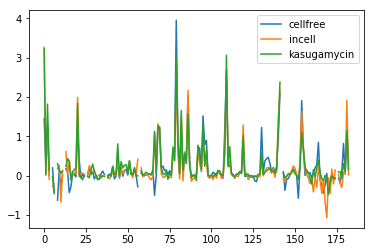

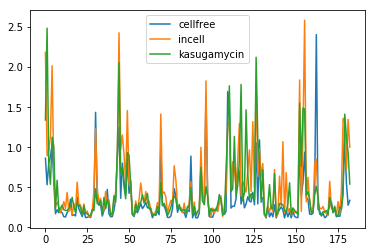

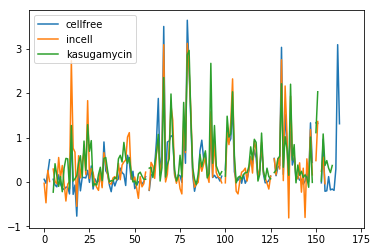

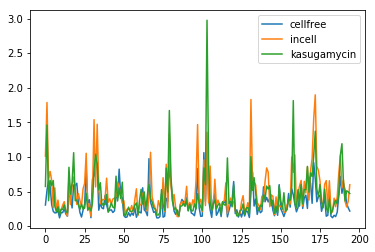

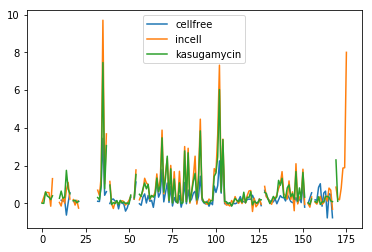

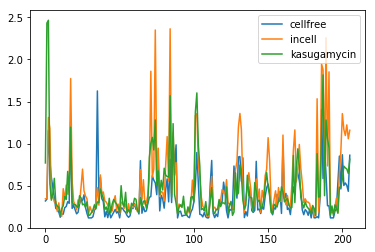

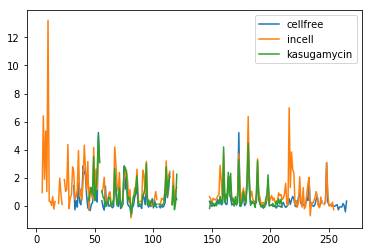

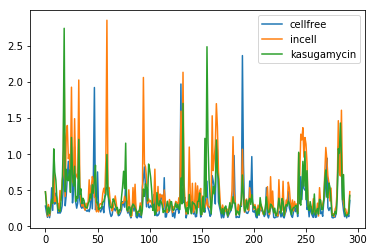

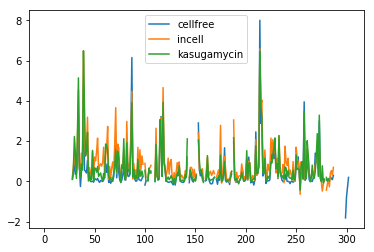

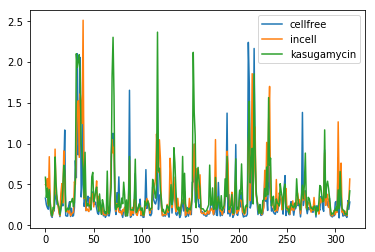

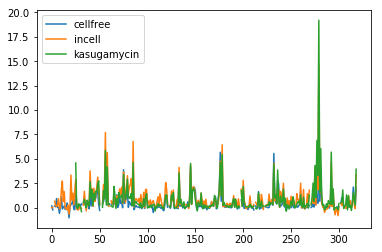

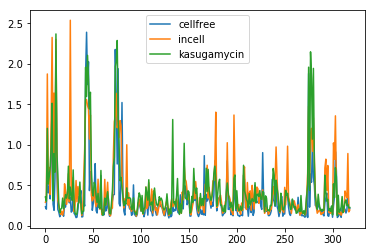

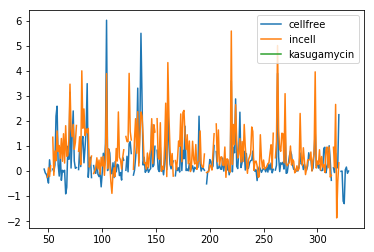

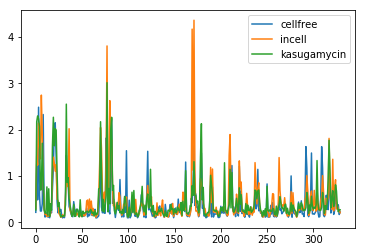

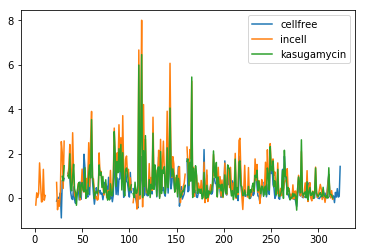

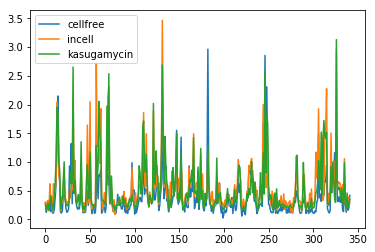

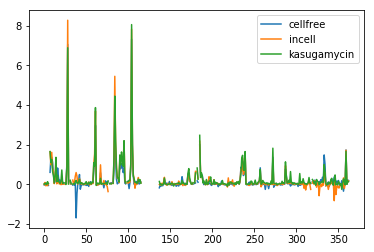

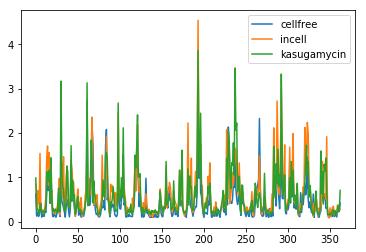

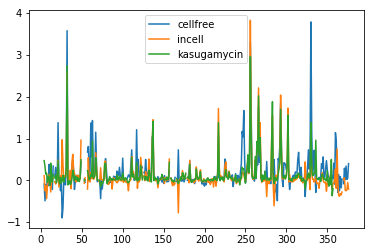

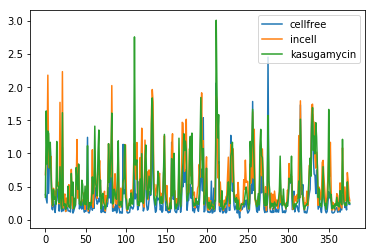

In [4]:

real = [pandas.DataFrame([data[a][k][0] for a in range(3)],index=types) for k in keys]

for r,b in zip(real,blobs):
    r.T.plot.line()
    b.T.plot.line()



# get

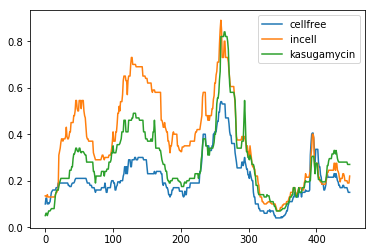

In [5]:
# GRAPH FROM PAPER 
def window(stuff):
    return [ np.median(np.array( [z for z in stuff[i:i+51] if z != None] )) for i in range(0, len(stuff)-50)  ]


papr = pandas.DataFrame( [ window(data[a]["rpsP_rimM_trmD_rplS_96"][0][:500]) for a in range(3)],index=types)
papr.T.plot.line()

#   

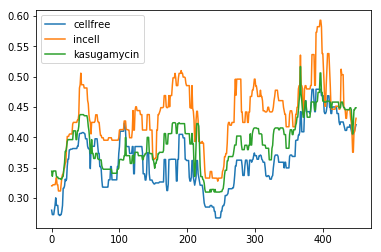

In [14]:
# SHAKER RECONSTRUCTION   # GRADIENT BOOST OPTIMIZED
def window(stuff):
    return [ np.median(np.array( [z for z in stuff[i:i+51] if z != None] )) for i in range(0, len(stuff)-50)  ]

keys = data[0].keys()
keys.remove("rpsP_rimM_trmD_rplS_96")
keys = keys[:10]
models = [ss.make_model(dat,keys,model=ss.make_xgbreg()) for dat in data ]
predictions = [ss.predict(mod, data[0]["rpsP_rimM_trmD_rplS_96"][1][:500]) for mod in models]

mystuff = pandas.DataFrame( [ window(p) for p in predictions],index=types)
mystuff.T.plot.line()

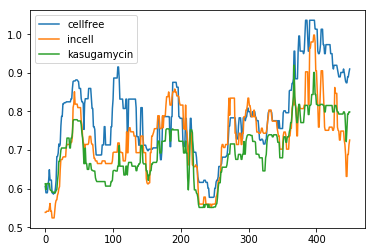

In [16]:
def nv(dat):
    arrays = np.hstack([a for a,b,c in dat.values()])
    return np.mean(arrays[arrays!=None])
normaliationvalues= map(nv,data)
windowed = [ [ep/z for ep in window(p)] for p,z in zip(predictions,normaliationvalues)]
mystuff = pandas.DataFrame(windowed,index=types)
mystuff.T.plot.line()

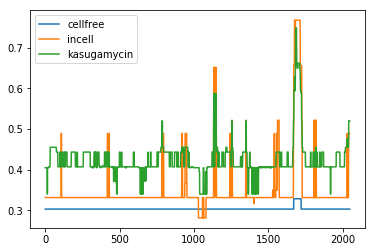

In [7]:
# SHAKER RECONSTRUCTION 
def window(stuff):
    return np.array([ np.median(np.array( [z for z in stuff[i:i+51] if z != None] )) for i in range(0, len(stuff)-50)  ])

keys = data[0].keys()
keys.remove("rpsP_rimM_trmD_rplS_96")
keys = keys[:10]
models = [ss.make_model(dat,keys,model=ss.make_forestregressor()) for dat in data ]
predictions = [ss.predict(mod, data[0]["rpsP_rimM_trmD_rplS_96"][1]) for mod in models]
mystuff = pandas.DataFrame( [ window(p) for p in predictions],index=types)
mystuff.T.plot.line()

In [ ]:
# RANDOM FOREST OPTIMIZED
#predictions = [ss.predict(mod, data[0]["rpsP_rimM_trmD_rplS_96"][1])[:500] for mod in models] 

def nv(dat):
    arrays = np.hstack([a for a,b,c in dat.values()])
    return np.mean(arrays[arrays!=None])
normaliationvalues= map(nv,data)
windowed = [ window(p)/z for p,z in zip(predictions,normaliationvalues)]
mystuff = pandas.DataFrame(windowed,index=types)
mystuff.T.plot.line()

In [ ]:
# SHAKER RECONSTRUCTION   RANFOM FOREST UNO}
''' # 2 slow!
def window(stuff):
    return [ np.median(np.array( [z for z in stuff[i:i+51] if z != None] )) for i in range(0, len(stuff)-50)  ]

keys = data[0].keys()
keys.remove("rpsP_rimM_trmD_rplS_96")
models = [ss.make_model(dat,keys,model=ss.RandomForestRegressor()) for dat in data ]
predictions = [ss.predict(mod, data[0]["rpsP_rimM_trmD_rplS_96"][1])[:500] for mod in models]
mystuff = pandas.DataFrame( [ window(p) for p in predictions],index=types)
mystuff.T.plot.line()
'''

---